<a href="https://colab.research.google.com/github/akanksharai0407/NeuroGen/blob/main/NeuGen_APAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install all dependencies
!pip install  kaggle
!pip install  gTTS
!pip install  transformers
!pip install  seaborn

# import all libraries

# sytem & I/O
import os
import random
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Audio
from gtts import gTTS
import IPython.display as ipd
import tempfile

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# Sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"akanksharai4701","key":"92b764532c1de1a2d532489a03a0272f"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d birdy654/eeg-brainwave-dataset-feeling-emotions
! unzip -o eeg-brainwave-dataset-feeling-emotions.zip -d eeg-emotion_data

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/birdy654/eeg-brainwave-dataset-feeling-emotions
License(s): copyright-authors
eeg-brainwave-dataset-feeling-emotions.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  eeg-brainwave-dataset-feeling-emotions.zip
  inflating: eeg-emotion_data/emotions.csv  


In [ ]:
df = pd.read_csv('eeg-emotion_data/emotions.csv')
print("shape:", df.shape)
print("columns:", df.columns[:5].tolist(), '...')
display(df.head())

shape: (2132, 2549)
columns: ['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a'] ...


,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [ ]:
# Encode emotion labels and normalize EEG features

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

X = df.drop(['label', 'label_encoded'], axis=1).values
y = df['label_encoded'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Encoded labels:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Feature shape:", X_scaled.shape)

Encoded labels: {'NEGATIVE': np.int64(0), 'NEUTRAL': np.int64(1), 'POSITIVE': np.int64(2)}
Feature shape: (2132, 2548)


In [ ]:
# Stratified train/validation/test split
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 1492
Validation size: 320
Test size: 320


In [ ]:
# Creating EEGDataset class and dataLoaders

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
test_dataset = EEGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# CNN model

class EEG_CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EEG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1)

        def conv1d_output_size(input_size, kernel_size, stride=1, padding=0, dilation=1):
            return ((input_size + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1

        c1_out_size = conv1d_output_size(input_size, kernel_size=5, stride=1)
        p1_out_size = conv1d_output_size(c1_out_size, kernel_size=2, stride=2)
        c2_out_size = conv1d_output_size(p1_out_size, kernel_size=3, stride=1)
        p2_out_size = conv1d_output_size(c2_out_size, kernel_size=2, stride=2)


        self.fc1 = nn.Linear(32 * p2_out_size, 64)
        self.fc2 = nn.Linear(64, num_classes)


    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

input_size = X_train.shape[1]
num_classes = 3

model = EEG_CNN(input_size=input_size, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

EEG_CNN(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=20320, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
# Training the CNN model

def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

train_model(model, train_loader, val_loader, epochs=20, lr=0.001)

Epoch 1: Loss = 19.5367, Train Acc = 0.6836, Val Acc = 0.9031
Epoch 2: Loss = 5.9374, Train Acc = 0.9216, Val Acc = 0.8812
Epoch 3: Loss = 4.3596, Train Acc = 0.9229, Val Acc = 0.9406
Epoch 4: Loss = 2.7104, Train Acc = 0.9672, Val Acc = 0.9406
Epoch 5: Loss = 2.1600, Train Acc = 0.9732, Val Acc = 0.9469
Epoch 6: Loss = 1.6177, Train Acc = 0.9799, Val Acc = 0.9656
Epoch 7: Loss = 1.3130, Train Acc = 0.9866, Val Acc = 0.9625
Epoch 8: Loss = 1.4375, Train Acc = 0.9806, Val Acc = 0.9719
Epoch 9: Loss = 0.6796, Train Acc = 0.9960, Val Acc = 0.9625
Epoch 10: Loss = 0.3524, Train Acc = 1.0000, Val Acc = 0.9688
Epoch 11: Loss = 0.2722, Train Acc = 1.0000, Val Acc = 0.9625
Epoch 12: Loss = 0.2237, Train Acc = 1.0000, Val Acc = 0.9594
Epoch 13: Loss = 0.1857, Train Acc = 1.0000, Val Acc = 0.9750
Epoch 14: Loss = 0.1215, Train Acc = 1.0000, Val Acc = 0.9719
Epoch 15: Loss = 0.0965, Train Acc = 1.0000, Val Acc = 0.9594
Epoch 16: Loss = 0.0947, Train Acc = 1.0000, Val Acc = 0.9719
Epoch 17: Loss =

              precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98       107
     NEUTRAL       1.00      0.97      0.99       107
    POSITIVE       0.96      0.97      0.97       106

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320



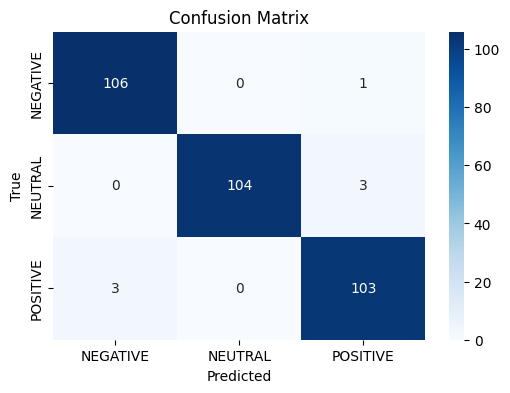

In [ ]:
# Evaluation of model on test set

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# EEGNet model

class EEGNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EEGNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=64, padding=32, bias=False),
            nn.BatchNorm1d(8),
            nn.Conv1d(8, 16, kernel_size=1, bias=False),
            nn.BatchNorm1d(16),
            nn.ELU(),
            nn.AvgPool1d(kernel_size=4),
            nn.Dropout(0.25)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=16, padding=8, bias=False),
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.AvgPool1d(kernel_size=8),
            nn.Dropout(0.25)
        )
        self.fc = nn.Linear(self._get_flattened_size(input_size), num_classes)

    def _get_flattened_size(self, input_size):
        with torch.no_grad():
            x = torch.zeros(1, 1, input_size)
            x = self.layer1(x)
            x = self.layer2(x)
            return x.shape[1] * x.shape[2]

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Initialization

eegnet_model = EEGNet(input_size=X_train.shape[1], num_classes=3)
eegnet_model.to(device)

EEGNet(
  (layer1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(64,), stride=(1,), padding=(32,), bias=False)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv1d(8, 16, kernel_size=(1,), stride=(1,), bias=False)
    (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
    (6): Dropout(p=0.25, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(16,), stride=(1,), padding=(8,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool1d(kernel_size=(8,), stride=(8,), padding=(0,))
    (4): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=2528, out_features=3, bias=True)
)

In [ ]:
# Training EEGNet
train_model(eegnet_model, train_loader, val_loader, epochs=20, lr=0.001)

Epoch 1: Loss = 9.3558, Train Acc = 0.8378, Val Acc = 0.8906
Epoch 2: Loss = 4.9722, Train Acc = 0.9155, Val Acc = 0.9125
Epoch 3: Loss = 4.3545, Train Acc = 0.9202, Val Acc = 0.9125
Epoch 4: Loss = 3.8455, Train Acc = 0.9357, Val Acc = 0.8969
Epoch 5: Loss = 3.7306, Train Acc = 0.9464, Val Acc = 0.9219
Epoch 6: Loss = 3.1889, Train Acc = 0.9450, Val Acc = 0.9344
Epoch 7: Loss = 2.9874, Train Acc = 0.9564, Val Acc = 0.9156
Epoch 8: Loss = 2.7560, Train Acc = 0.9558, Val Acc = 0.9500
Epoch 9: Loss = 2.5848, Train Acc = 0.9605, Val Acc = 0.9250
Epoch 10: Loss = 2.3061, Train Acc = 0.9665, Val Acc = 0.9375
Epoch 11: Loss = 2.3244, Train Acc = 0.9672, Val Acc = 0.9344
Epoch 12: Loss = 2.1403, Train Acc = 0.9712, Val Acc = 0.9500
Epoch 13: Loss = 2.0892, Train Acc = 0.9685, Val Acc = 0.9344
Epoch 14: Loss = 1.9866, Train Acc = 0.9678, Val Acc = 0.9344
Epoch 15: Loss = 1.6982, Train Acc = 0.9718, Val Acc = 0.9500
Epoch 16: Loss = 2.1997, Train Acc = 0.9658, Val Acc = 0.9281
Epoch 17: Loss = 

              precision    recall  f1-score   support

    NEGATIVE       0.96      0.97      0.97       107
     NEUTRAL       0.99      0.98      0.99       107
    POSITIVE       0.95      0.95      0.95       106

    accuracy                           0.97       320
   macro avg       0.97      0.97      0.97       320
weighted avg       0.97      0.97      0.97       320



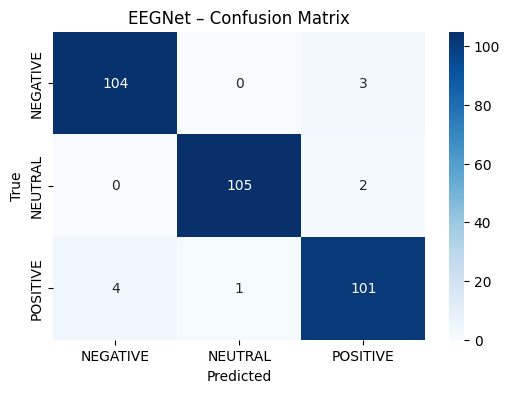

In [ ]:
# Evaluation of EEGNet on test set
eegnet_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = eegnet_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EEGNet – Confusion Matrix")
plt.show()

In [ ]:
# Reshaping the features for LSTM input

time_steps = 49
features_per_step = 52

X_train_seq = X_train.reshape(-1, time_steps, features_per_step)
X_val_seq   = X_val.reshape(-1, time_steps, features_per_step)
X_test_seq  = X_test.reshape(-1, time_steps, features_per_step)

print("Reshaped X_train:", X_train_seq.shape)

Reshaped X_train: (1492, 49, 52)


In [ ]:
# PyTorch Dataset for LSTM
class EEGLSTMDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_dataset_lstm = EEGLSTMDataset(X_train_seq, y_train)
val_dataset_lstm = EEGLSTMDataset(X_val_seq, y_val)
test_dataset_lstm = EEGLSTMDataset(X_test_seq, y_test)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size, shuffle=True)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=batch_size)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size)

In [ ]:
# EEG_LSTM model

class EEG_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(EEG_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
input_size = 52
hidden_size = 64
num_layers = 2
num_classes = 3

model_lstm = EEG_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

In [ ]:
# Training the LSTM model
train_model(model_lstm, train_loader_lstm, val_loader_lstm, epochs=20, lr=0.001)

Epoch 1: Loss = 23.5395, Train Acc = 0.6381, Val Acc = 0.7937
Epoch 2: Loss = 11.1142, Train Acc = 0.8324, Val Acc = 0.9031
Epoch 3: Loss = 6.3721, Train Acc = 0.8995, Val Acc = 0.9031
Epoch 4: Loss = 5.3757, Train Acc = 0.9182, Val Acc = 0.9031
Epoch 5: Loss = 4.7659, Train Acc = 0.9283, Val Acc = 0.9062
Epoch 6: Loss = 3.9373, Train Acc = 0.9430, Val Acc = 0.9250
Epoch 7: Loss = 3.6818, Train Acc = 0.9538, Val Acc = 0.9437
Epoch 8: Loss = 3.4457, Train Acc = 0.9491, Val Acc = 0.9437
Epoch 9: Loss = 3.0269, Train Acc = 0.9571, Val Acc = 0.9344
Epoch 10: Loss = 2.6582, Train Acc = 0.9665, Val Acc = 0.9500
Epoch 11: Loss = 2.4617, Train Acc = 0.9685, Val Acc = 0.9469
Epoch 12: Loss = 2.2619, Train Acc = 0.9732, Val Acc = 0.9500
Epoch 13: Loss = 2.2717, Train Acc = 0.9752, Val Acc = 0.9375
Epoch 14: Loss = 1.8321, Train Acc = 0.9765, Val Acc = 0.9469
Epoch 15: Loss = 1.7893, Train Acc = 0.9806, Val Acc = 0.9313
Epoch 16: Loss = 2.3612, Train Acc = 0.9732, Val Acc = 0.9563
Epoch 17: Loss 

              precision    recall  f1-score   support

    NEGATIVE       0.93      0.94      0.94       107
     NEUTRAL       0.97      0.97      0.97       107
    POSITIVE       0.91      0.90      0.90       106

    accuracy                           0.94       320
   macro avg       0.94      0.94      0.94       320
weighted avg       0.94      0.94      0.94       320



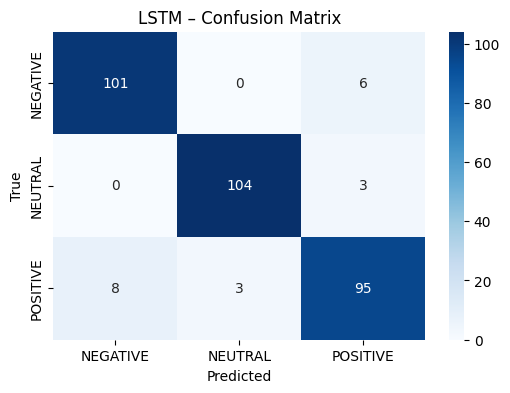

In [ ]:
# Evaluation of LSTM on Test set
model_lstm.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_lstm:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_lstm(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("LSTM – Confusion Matrix")
plt.show()

In [ ]:
# Defining a Smaller Student Model
class StudentCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(StudentCNN, self).__init__()
        self.conv = nn.Conv1d(1, 8, kernel_size=5, stride=1)
        self.pool = nn.MaxPool1d(2)

        def conv1d_output_size(input_size, kernel_size, stride=1, padding=0, dilation=1):
            return ((input_size + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1

        c1_out_size = conv1d_output_size(input_size, kernel_size=5, stride=1)
        p1_out_size = conv1d_output_size(c1_out_size, kernel_size=2, stride=2)

        self.fc1 = nn.Linear(8 * p1_out_size, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(F.relu(self.conv(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

student_model = StudentCNN(input_size=X_train.shape[1], num_classes=3).to(device)

In [ ]:
# Distillation Loss Function
def distillation_loss(y_student, y_teacher, y_true, temperature=4, alpha=0.7):
    """
    y_student: logits from student
    y_teacher: logits from teacher
    y_true: true labels
    temperature: softening temperature
    alpha: weight for soft loss
    """
    soft_loss = nn.KLDivLoss()(F.log_softmax(y_student/temperature, dim=1),
                               F.softmax(y_teacher/temperature, dim=1)) * (temperature**2)
    hard_loss = F.cross_entropy(y_student, y_true)
    return alpha * soft_loss + (1 - alpha) * hard_loss

In [ ]:
# Training Student with distillation
def train_distillation(student_model, teacher_model, train_loader, val_loader, epochs=20, lr=0.001):
    optimizer = optim.Adam(student_model.parameters(), lr=lr)
    teacher_model.eval()

    for epoch in range(epochs):
        student_model.train()
        total_loss = 0
        correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            optimizer.zero_grad()
            student_outputs = student_model(inputs)

            loss = distillation_loss(student_outputs, teacher_outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(student_outputs, 1)
            correct += (predicted == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)

        # Validation
        student_model.eval()
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

In [ ]:
# distillation training
train_distillation(student_model, model, train_loader, val_loader, epochs=20, lr=0.001)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1: Loss = 36.8715, Train Acc = 0.7869, Val Acc = 0.8375


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 2: Loss = 12.2677, Train Acc = 0.9189, Val Acc = 0.9313


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 3: Loss = 6.1282, Train Acc = 0.9544, Val Acc = 0.9437


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 4: Loss = 4.0053, Train Acc = 0.9685, Val Acc = 0.9531


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 5: Loss = 3.3945, Train Acc = 0.9772, Val Acc = 0.9563


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 6: Loss = 2.5865, Train Acc = 0.9812, Val Acc = 0.9187


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 7: Loss = 2.2707, Train Acc = 0.9799, Val Acc = 0.9531


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 8: Loss = 1.3544, Train Acc = 0.9893, Val Acc = 0.9563


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 9: Loss = 1.0875, Train Acc = 0.9920, Val Acc = 0.9594


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 10: Loss = 0.8711, Train Acc = 0.9926, Val Acc = 0.9594


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 11: Loss = 0.7155, Train Acc = 0.9966, Val Acc = 0.9625


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 12: Loss = 0.5978, Train Acc = 0.9973, Val Acc = 0.9656


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 13: Loss = 0.4587, Train Acc = 0.9993, Val Acc = 0.9625


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 14: Loss = 0.3991, Train Acc = 0.9993, Val Acc = 0.9656


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 15: Loss = 0.3952, Train Acc = 0.9993, Val Acc = 0.9656


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 16: Loss = 0.3081, Train Acc = 0.9993, Val Acc = 0.9656


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 17: Loss = 0.2719, Train Acc = 0.9993, Val Acc = 0.9656


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 18: Loss = 0.2631, Train Acc = 1.0000, Val Acc = 0.9656


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 19: Loss = 0.2131, Train Acc = 1.0000, Val Acc = 0.9656


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 20: Loss = 0.2089, Train Acc = 1.0000, Val Acc = 0.9688


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


              precision    recall  f1-score   support

    NEGATIVE       0.95      0.99      0.97       107
     NEUTRAL       1.00      0.97      0.99       107
    POSITIVE       0.96      0.94      0.95       106

    accuracy                           0.97       320
   macro avg       0.97      0.97      0.97       320
weighted avg       0.97      0.97      0.97       320



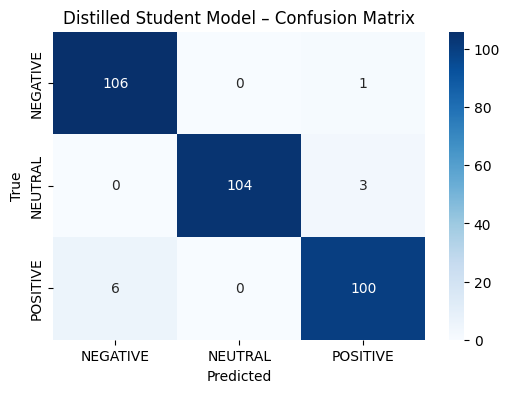

In [ ]:
# Evaluating distilled Student model on test Set
student_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = student_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Distilled Student Model – Confusion Matrix")
plt.show()

In [ ]:
model_results = {
    'Model': ['1D CNN (Teacher)', 'EEGNet', 'LSTM', 'Distilled CNN'],
    'Test Accuracy': [0.98, 0.96, 0.93, 0.97],
    'Macro F1 Score': [0.98, 0.96, 0.93, 0.97],
    'Notes': [
        'Largest model, highest accuracy',
        'EEG-specific, compact',
        'Temporal dynamics captured',
        'Smallest, nearly same accuracy'
    ]
}

results_df = pd.DataFrame(model_results)
print(results_df)

              Model  Test Accuracy  Macro F1 Score  \
0  1D CNN (Teacher)           0.98            0.98   
1            EEGNet           0.96            0.96   
2              LSTM           0.93            0.93   
3     Distilled CNN           0.97            0.97   

                             Notes  
0  Largest model, highest accuracy  
1            EEG-specific, compact  
2       Temporal dynamics captured  
3   Smallest, nearly same accuracy  


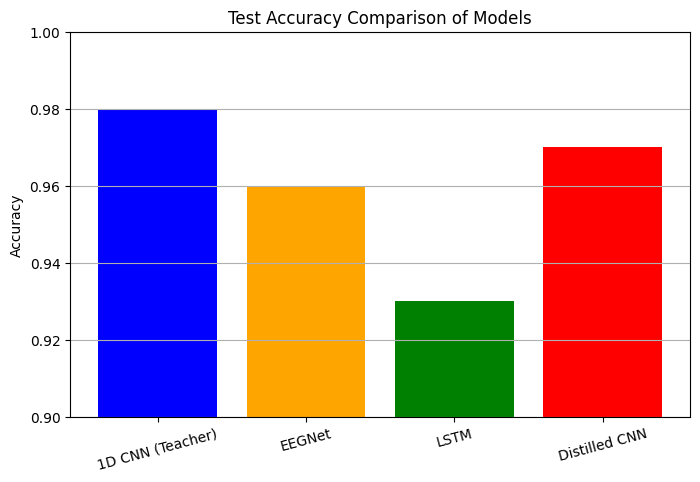

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['Test Accuracy'], color=['blue', 'orange', 'green', 'red'])
plt.ylim([0.9, 1.0])
plt.title('Test Accuracy Comparison of Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

In [ ]:
# GPT-2 Text Generation
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
model_gpt2.eval()

def generate_sentence_gpt2(emotion_label, max_length=30):
    prompt = f"The person is feeling {emotion_label.lower()}. Encourage them with a helpful sentence:"
    input_ids = tokenizer.encode(prompt, return_tensors='pt')

    with torch.no_grad():
        output = model_gpt2.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    sentence = generated_text.replace(prompt, "").strip()
    return sentence

# example
for emotion in ['NEGATIVE', 'NEUTRAL', 'POSITIVE']:
    print(f"{emotion} → {generate_sentence_gpt2(emotion)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


NEGATIVE → "I'm sorry, but I'm not sure what to do."
NEUTRAL → "I'm not going to hurt you."

"I don't know
POSITIVE → "I'm feeling good."

"I feel good," says the person


In [ ]:
# Text-to-Speech (TTS) using gTTS
def speak_text(text, lang='en'):
    tts = gTTS(text=text, lang=lang)
    with tempfile.NamedTemporaryFile(delete=True) as fp:
        tts.save("temp.mp3")
        return ipd.Audio("temp.mp3")

# Example
sample_text = generate_sentence_gpt2('POSITIVE')
print("Generated sentence:", sample_text)
speak_text(sample_text)

Generated sentence: "I'm feeling good."

"I feel good," says the person


In [ ]:
emotions = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']

for emotion in emotions:
    sentence = generate_sentence_gpt2(emotion)
    print(f"Emotion: {emotion}")
    print(f"Generated sentence: {sentence}")
    display(speak_text(sentence))
    print('---')

Emotion: NEGATIVE
Generated sentence: "I'm sorry, but I'm not sure what to do."


---
Emotion: NEUTRAL
Generated sentence: "I'm not going to hurt you."

"I don't know


---
Emotion: POSITIVE
Generated sentence: "I'm feeling good."

"I feel good," says the person


---
